# Project 1 (Due Nov 13)

The goal of the first project is to non-parametrically model some phenomenon of interest, and generate sequences of values. There are six options below:

- Chordonomicon: 680,000 chord progressions of popular music songs. Create a chord generator, similar to what we did with Bach in class, but for a particular artist or genre. (https://github.com/spyroskantarelis/chordonomicon)
- Financial Time series, S&P500 Stocks: There are 500 time series here. Model how individual time series adjust over time, either together or separately. (https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks)
- MIT-BIT Arrythmia Database: Arrythmia is an abnormal heart rhythm. This is a classic dataset that a day of ECG time series measurements for 4,000 patients. (https://www.physionet.org/content/mitdb/1.0.0/)
- Ukraine conflict monitor: The ACLED Ukraine Conflict Monitor provides near real-time information on the ongoing war in Ukraine, including an interactive map, a curated data file, and weekly situation updates Ukraine Conflict Monitor, maintained by the Armed Conflict Location & Event Data Project, starting in 2022, including battles, explosions/remote violence, violence against civilians, protests, and riots:
https://acleddata.com/monitor/ukraine-conflict-monitor
- SIPRI Arms Trade: The SIPRI Arms Transfers Database is a comprehensive public resource tracking all international transfers of major conventional arms from 1950 to the present. For each deal, information includes: number ordered, supplier/recipient identities, weapon types, delivery dates, and deal comments. The database can address questions about: who are suppliers and recipients of major weapons, what weapons have been transferred by specific countries, and how supplier-recipient relationships have changed over time.
https://www.sipri.org/databases/armstransfers
- Environmental Protection Agency data: The EPA, in general, has excellent data on the release of toxic substances, and I also tracked down air quality and asthma. You can put these together to look at how changes in toxic release correlate with air quality and respiratory disease over time:
https://www.epa.gov/data
https://www.epa.gov/toxics-release-inventory-tri-program/tri-toolbox
https://www.cdc.gov/asthma/most_recent_national_asthma_data.htm
https://www.earthdata.nasa.gov/topics/atmosphere/air-quality/data-access-tools

If you have other data sources that you're interested in, I am willing to consider them, as long as they lend themselves to an interesting analysis.

Submit a document or notebook that clearly addresses the following:
1. Describe the data clearly -- particularly any missing data that might impact your analysis -- and the provenance of your dataset. Who collected the data and why? (10/100 pts)
2. What phenomenon are you modeling? Provide a brief background on the topic, including definitions and details that are relevant to your analysis. Clearly describe its main features, and support those claims with data where appropriate. (10/100 pts)
3. Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts)
4. Either use your model to create new sequences (if the model is more generative) or bootstrap a quantity of interest (if the model is more inferential). (15/100 pts)
5. Critically evaluate your work in part 4. Do your sequences have the properties of the training data, and if not, why not? Are your estimates credible and reliable, or is there substantial uncertainty in your results? (15/100 pts)
6. Write a conclusion that explains the limitations of your analysis and potential for future work on this topic. (10/100 pts)

In addition, submit a GitHub repo containing your code and a description of how to obtain the original data from the source. Make sure the code is commented, where appropriate. Include a .gitignore file. We will look at your commit history briefly to determine whether everyone in the group contributed. (10/100 pts)

In class, we'll briefly do presentations and criticize each other's work, and participation in your group's presentation and constructively critiquing the other groups' presentations accounts for the remaining 15/100 pts.


## Data Description and Provenance

In [5]:
import pandas as pd
import numpy as np


# Load files
companies = pd.read_csv('data/sp500_companies.csv')
index_df  = pd.read_csv('data/sp500_index.csv')
stocks    = pd.read_csv('data/sp500_stocks.csv')


# Convert dates
index_df['Date'] = pd.to_datetime(index_df['Date'], errors='coerce')
stocks['Date']   = pd.to_datetime(stocks['Date'],   errors='coerce')


def missing_report(df, name):
   print(f"\n=== {name} ===")
   print(f"Shape: {df.shape}")
   if 'Date' in df.columns:
       print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
   missing = df.isnull().sum()
   percent = 100 * missing / len(df)
   report = pd.DataFrame({'Missing Count': missing, 'Percent Missing': percent})
   report = report[report['Missing Count'] > 0].sort_values('Percent Missing', ascending=False)
   if not report.empty:
       print("Missing values:")
       print(report.round(3))
   else:
       print("No missing values in any column.")
   print("-" * 50)


missing_report(companies, "data/sp500_companies.csv")
missing_report(index_df,  "data/sp500_index.csv")
missing_report(stocks,    "data/sp500_stocks.csv")


=== data/sp500_companies.csv ===
Shape: (502, 16)
Missing values:
                   Missing Count  Percent Missing
Ebitda                        29            5.777
State                         20            3.984
Fulltimeemployees              9            1.793
Revenuegrowth                  3            0.598
--------------------------------------------------

=== data/sp500_index.csv ===
Shape: (2517, 2)
Date range: 2014-12-22 00:00:00 to 2024-12-20 00:00:00
No missing values in any column.
--------------------------------------------------

=== data/sp500_stocks.csv ===
Shape: (1891536, 8)
Date range: 2010-01-04 00:00:00 to 2024-12-20 00:00:00
Missing values:
           Missing Count  Percent Missing
Adj Close         100475            5.312
Close             100475            5.312
High              100475            5.312
Low               100475            5.312
Open              100475            5.312
Volume            100475            5.312
------------------------------

### Data Description and Missing Value Summary

This project uses three related datasets describing the S&P 500 index and its constituent companies.

(a) sp500_companies.csv

- Shape: (502 × 16)  
- Description: Contains company-level metadata and financial indicators for S&P 500 constituents.  
- Key columns: Exchange, Symbol, Shortname, Sector, Industry, Currentprice, Marketcap, Ebitda, Revenuegrowth, Fulltimeemployees, etc.  

Missing Data:

| Column             | Missing Count | Percent Missing |
|--------------------|---------------|-----------------|
| Ebitda             | 29            | 5.78%           |
| State              | 20            | 3.98%           |
| Fulltimeemployees  | 9             | 1.79%           |
| Revenuegrowth      | 3             | 0.60%           |

Interpretation: 
Most missing data appear in financial fields (Ebitda, Revenuegrowth) and location-related fields (State).  
These gaps likely stem from incomplete corporate disclosures or companies headquartered outside the U.S.  
The dataset otherwise has complete coverage of essential identification and classification fields such as Symbol and Sector.

(b) sp500_index.csv

- Shape: (2,517 × 2)  
- Date range: 2014-12-22 → 2024-12-20  
- Columns: Date, S&P500 (daily closing level).  
- Missing data: None detected.  

Interpretation:  
The index file is fully complete, covering approximately ten years of daily observations.  
This makes it an ideal foundation for modeling index-level returns or volatility.

(c) sp500_stocks.csv

- Shape: (1,891,536 × 8)  
- Date range: 2010-01-04 → 2024-12-20  
- Columns: Date, Symbol, Open, High, Low, Close, Adj Close, Volume.  

Missing Data:

| Column     | Missing Count | Percent Missing |
|-------------|----------------|-----------------|
| Adj Close   | 100,475        | 5.31%           |
| Close       | 100,475        | 5.31%           |
| High        | 100,475        | 5.31%           |
| Low         | 100,475        | 5.31%           |
| Open        | 100,475        | 5.31%           |
| Volume      | 100,475        | 5.31%           |

Interpretation:  
We will investigate the missing values further in the next code block.

### Data Provenance

The datasets used in this project originate from the Kaggle dataset  
**[“S&P 500 Stocks”](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks)**.  
This dataset aggregates information about S&P 500 companies, their historical prices, and the overall index level.

Source Details:
- Platform: Kaggle  
- Dataset Owner: Larxel (dataset maintainer)  
- Collection Methodology: Data collected from the Federal Reserve Economic Data (FRED) and the Yahoo Finance (yfinance) API.  
- License: CC0: Public Domain 
- Update Frequency: Daily (last updated approximately one year ago)  
- Temporal Coverage: 2010–2024   
- Dataset Version Used: v1022 (the most recent reliable version)  

> Note:
> The latest version of the dataset (v1023) contains approximately 67% missing values, rendering it unsuitable for analysis.  
> Therefore, this project uses version 1022, which provides complete and consistent coverage for the S&P 500 index and its constituent stock data. 

In [6]:
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
full_missing = stocks[price_cols].isna().all(axis=1)


# 1. Count missing rows per ticker
missing_per_ticker = (
   full_missing.groupby(stocks['Symbol'])
   .sum()
   .astype(int)
   .sort_values(ascending=False)
)


# 2. Show results
print(f"Total missing rows: {full_missing.sum():,}")
print(f"Tickers with missing data: {missing_per_ticker[missing_per_ticker > 0].shape[0]}")


print("\n--- Top 15 tickers with MOST missing days ---")
print(missing_per_ticker.head(15).to_string())

Total missing rows: 100,475
Tickers with missing data: 72

--- Top 15 tickers with MOST missing days ---
Symbol
AMTM    3705
SW      3650
GEV     3583
SOLV    3583
VLTO    3461
KVUE    3356
GEHC    3261
CEG     3032
ABNB    2754
PLTR    2704
OTIS    2569
CARR    2569
CRWD    2375
CTVA    2363
UBER    2353


### Missing values in `sp500_stocks.csv'

We examined which specific tickers had missing data in the sp500_stocks.csv dataset.  
Out of approximately 1.89 million rows (covering 2010–2024), there are 100,475 rows with missing values across *all* price and volume columns — about 5.31% of the dataset.  

Only 72 tickers are affected, primarily recent S&P 500 additions such as AMTM (3,705 missing days), SW, GEV, and SOLV (2024 spin-offs), followed by VLTO, KVUE, GEHC, CEG, ABNB, PLTR, OTIS, CARR, CRWD, CTVA, and UBER (added between 2019–2023).  

These gaps correspond to periods before each company joined the index, not data errors.  
They occur because the dataset spans the entire 2010–2024 period, even though many of these firms entered the S&P 500 mid-period.  
The remaining ~430 tickers have complete trading histories.  

This pattern of missingness is structural and expected, reflecting real-world index composition changes rather than issues with data collection.


## 3. Describe your non-parametric model 

Local constant least squares regression is a non-parametric regression that looks at each point of the dependent variable only in relation to the points surrounding it. The number of points surrounding it is defined by the bandwidth parameter. The choice of bandwidth is very important to the success of this model.

A key feature of this model is that the points around it are weighted with higher weights being assigned to points closest to the target point. The function used to assign weight is called the kernel. For a local least squares regression, multiple kernels are possible.

After the points are weighted, the weighted average of all the points within the bandwidth is assigned for prediction for the target variable. The weighted average is also called the local constant, which is also what gives this model its name.

While this model will not be difficult to code by hand due to its simplicity, but it is much easier to use statistical package such as one contained in the pyhton libray, statsmodels.

In [7]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import matplotlib.pyplot as plt

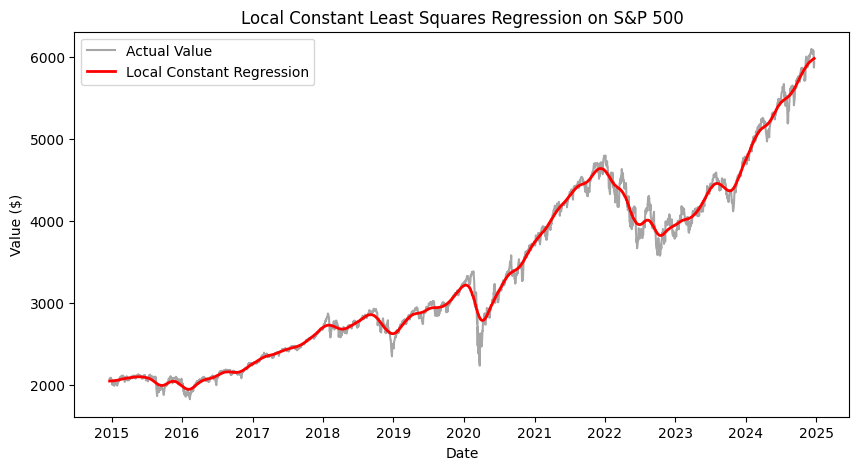

In [8]:
# Set dependent variable to stock price, and independent variable to a range of numbers starting at 0 and going up to 
# all of the stock prices
y = index_df['S&P500']
x = np.arange(len(y))

#Create model with bandwidth = 20 and kernel type to default Gaussian
lc_model = KernelReg([y],[x],var_type='c', reg_type='lc',bw = [20])

#Create predict values for every data point
y_pred = lc_model.fit(x)
y_pred = y_pred[0]

# Plot y and y_pred on the same plot
plt.figure(figsize=(10,5))
plt.plot(index_df['Date'], y, label='Actual Value', color='gray', alpha=0.7)
plt.plot(index_df['Date'], y_pred, label='Local Constant Regression', color='red', linewidth=2)
plt.title('Local Constant Least Squares Regression on S&P 500')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

In [9]:
#Printing evaluation metrix for the model
rmse = np.sqrt(np.mean((y-y_pred)**2))
mae= np.mean(np.abs(y-y_pred))
print('rmse:',round(rmse,5))
print('mae:', round(mae,5))

rmse: 76.61519
mae: 51.57929


The stats model kernel regression chose the appropriate bandwidth automatically using least squares validation. A different choice of bandwidth might yield different results. In particular, a higher bandwidth will lead to a smoother curve, but a higher rmse. This is an example of bias and variance trade off where a higher rmse might be more likely to generalize for future points since small variations in stock prices from day to day will not be predictable. Using a small bandwidth will result small error, but will be overfit to minor and random pattern in the data.

For this analysis, I used the S&P 500 index values due to their completeness. To model individual stocks, I would need to check if they were included in the data that I downloaded which had a significant amount of missing data.

## Markov Chain

To model the likelihood of bearish, bullish, or stable days, we split our dataset into a training set (up to 2020) and a test set (2020–2024). For each stock, we calculate the daily percent change in adjusted closing prices and classify each day into one of three states: Bear: negative percent change (market goes down)

Bull: positive percent change (market goes up)

Stable: percent change within a defined threshold

# Individual Stock level

This classification allows us to generate state sequences for each stock across the years, forming the basis for individual stock transition matrices, which capture the probability of moving from one state to another.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [12]:
sp_comp = pd.read_csv('data/sp500_companies.csv')
sp_index = pd.read_csv('data/sp500_index.csv')
sp_stocks = pd.read_csv('data/sp500_stocks.csv')

In [13]:
sp_stocks.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
1891531,2024-12-16,ZTS,175.809998,175.809998,179.289993,175.789993,177.990005,1938800.0
1891532,2024-12-17,ZTS,170.789993,170.789993,177.320007,169.520004,175.000000,3018300.0
1891533,2024-12-18,ZTS,167.009995,167.009995,170.940002,166.899994,170.070007,2728300.0
1891534,2024-12-19,ZTS,163.520004,163.520004,167.440002,163.369995,166.589996,3713700.0
1891535,2024-12-20,ZTS,164.839996,164.839996,166.389999,163.529999,163.759995,6220100.0


In [14]:
sp_stocks = sp_stocks.sort_values(['Date','Symbol'])
#Percent Change of Adj Close from previous day to the next day for each stock
sp_stocks['pct_change'] = sp_stocks.groupby('Symbol')['Adj Close'].pct_change()
#First row will return NaN since there is no previous day to compare 
sp_stocks = sp_stocks.dropna(subset=['pct_change'])

/var/folders/4t/5hj7kljd5g51dtz6_yd5cv240000gn/T/ipykernel_2273/423515512.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp_stocks['pct_change'] = sp_stocks.groupby('Symbol')['Adj Close'].pct_change()


## Threshold Decision

The threshold defines the range considered Stable. We experimented with values from 0.001 to 0.2. A threshold of 0.001 was small, barely reflecting stable days, while 0.2 was too large, resulting in most days being classified as stable. A threshold of 0.002 (0.2%) was chosen. This captures minor flat days as stable while keeping Bull and Bear proportions realistic.

In [15]:
# Creating state of 'bear' and 'bull'
# Bear: Market is down i.e. negative change
# Bull: Market is up i.e. positive change

threshold = 0.002

def classify_change(x):
    if x > threshold:
        return 'Bull'
    elif x < -threshold:
        return 'Bear'
    else:
        return 'Stable'
    
sp_stocks['State'] = sp_stocks['pct_change'].apply(classify_change)

In [16]:
sp_stocks['State'].value_counts(normalize=True)


State
Bull      0.459165
Bear      0.408890
Stable    0.131945
Name: proportion, dtype: float64

In [17]:
#Individual Markov chain according to each symbol/ticker
train = sp_stocks[sp_stocks['Date'] < '2020-01-01']


ticker = train['Symbol'].unique()
transition_matrices = {}

for t in ticker:
    ticker_state = train[train['Symbol'] == t].sort_values('Date')['State'].values
    transition_matrices[t] = pd.crosstab(ticker_state[:-1], ticker_state[1:], normalize='index')

In [18]:
transition_matrices['CCL']

col_0,Bear,Bull,Stable
row_0,,,
Bear,0.405458,0.461988,0.132554
Bull,0.420779,0.452814,0.126407
Stable,0.375375,0.471471,0.153153


# Interpretation

From the value counts of our states, we observe that daily movements are almost evenly split between Bull and Bear days, with Stable days accounting for around 13%. Examining a single stock like CCL, we find that it is 40% likely to move from Bear to Bear, 46% from Bear to Bull, and 13% from Bear to Stable, reflecting the randomness of stock movements.

## Sector-Level Analysis

After computing individual stock transition matrices, we aggregate them to the sector level.

In [19]:
#Creating a dataframe for each sector names and marketcap and weight according to symbols and their states
sp_sector = train.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [20]:
sp_sector.head()


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
0,2010-01-05,A,19.835201,22.145924,22.331903,22.002861,22.324751,4186031.0,-0.010863,Bear,Healthcare,38415384576,0.000691
1,2010-01-05,AAPL,6.458560,7.656429,7.699643,7.616071,7.664286,601904800.0,0.001729,Stable,Technology,3846819807232,0.069209
2,2010-01-05,ABT,18.612120,25.918797,26.134706,25.789249,26.134706,10562109.0,-0.008079,Bear,Healthcare,198127370240,0.003565
3,2010-01-05,ACGL,7.967778,7.967778,7.995556,7.910000,7.942222,3807000.0,-0.003336,Bear,Financial Services,34234257408,0.000616
4,2010-01-05,ACN,33.174648,42.330002,42.450001,41.980000,42.099998,2613000.0,0.006181,Bull,Technology,229157109760,0.004123


In [21]:
sector_groups = sp_sector[['Symbol','Sector']].drop_duplicates()


We first create a dictionary of all unique sectors, such as Healthcare, Technology, and Financial Services. Each sector is assigned a final transition matrix, which is a weighted average of the transition matrices of its constituent stocks, using market capitalization as weights. This ensures that larger companies’ influence on sector behavior is accounted for.

In [22]:
# Unique sectors
sectors = sector_groups['Sector'].unique()
sector_transitions = {}

for sector in sectors:

    # Going through the tickers in each sector
    symbol_sector = sector_groups[sector_groups['Sector'] == sector]['Symbol']
    # Creating a list for matrics and weights for each sector
    matrics, weights = [], []

    # Going through the tickers in each sector
    for t in symbol_sector:

        # Going through the transition matrices for each of the tickers
        if t in transition_matrices:
            # Adding the transition matrix of the ticker to the sector list
            matrics.append(transition_matrices[t])
            # Adding the weight of the ticker to the sector list
            weight = sp_comp.loc[sp_comp['Symbol'] == t, 'Marketcap'].values[0]
            weights.append(weight)

    if matrics:

        matrics = [m.values if isinstance(m, pd.DataFrame) else m for m in matrics]

        #Weighted_sum of the matrics and weights
        weighted_sum = sum(m*w for m,w in zip(matrics, weights))
        #Averaging out the weighted sum
        avg_matrix = weighted_sum / sum(weights)
        #Adding the transition matrix of each sector to a dictionary
        states = ['Bear', 'Bull', 'Stable']
        sector_transitions[sector] = pd.DataFrame(avg_matrix, index=states, columns=states)
        # sector_transitions[sector] = avg_matrix

In [23]:
sector_transitions['Financial Services']


,Bear,Bull,Stable
Bear,0.379935,0.486069,0.133996
Bull,0.414843,0.431542,0.153615
Stable,0.393714,0.433220,0.173066


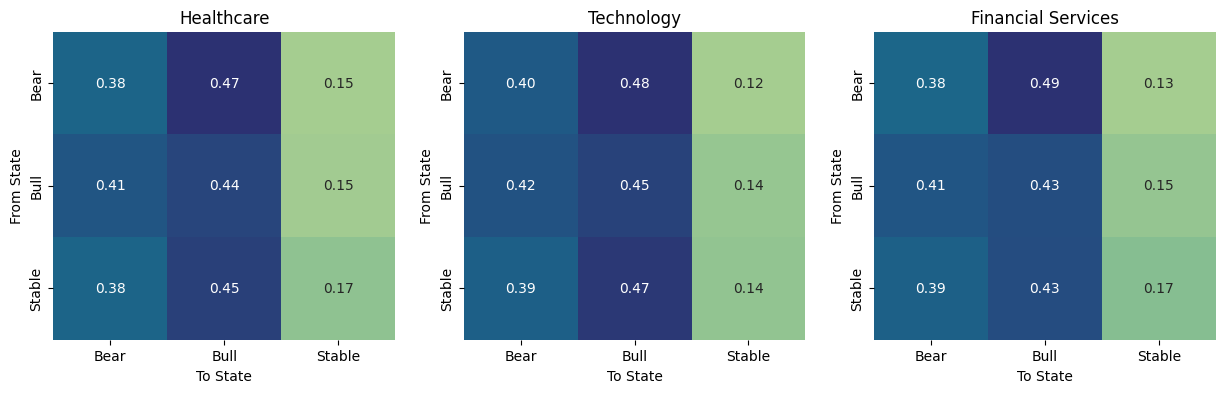

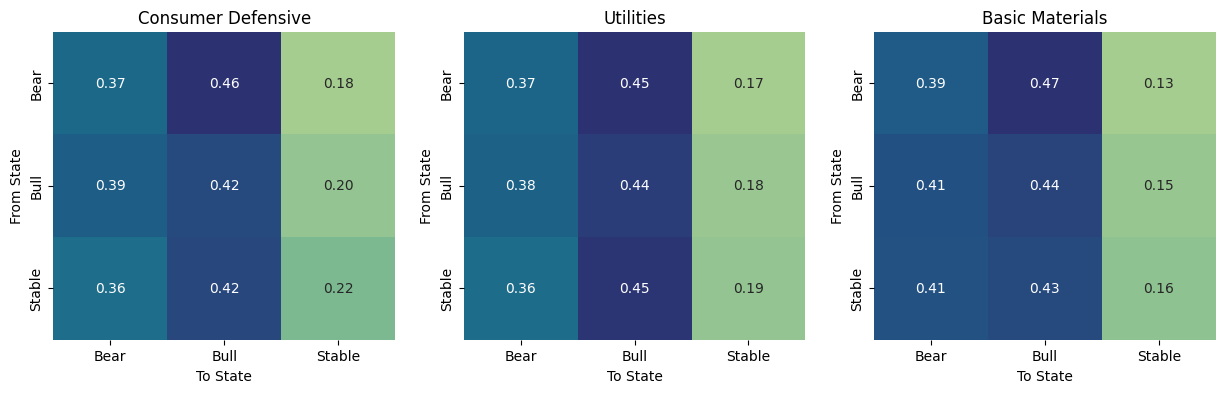

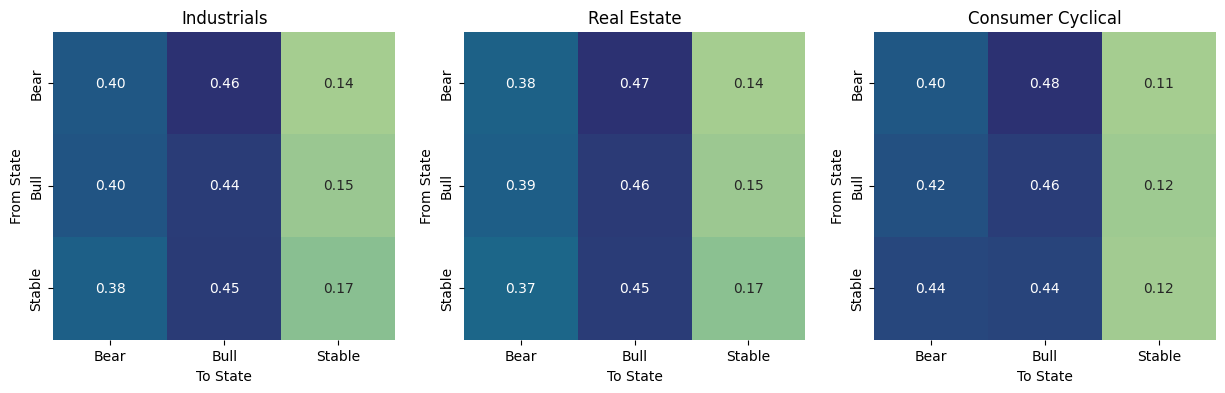

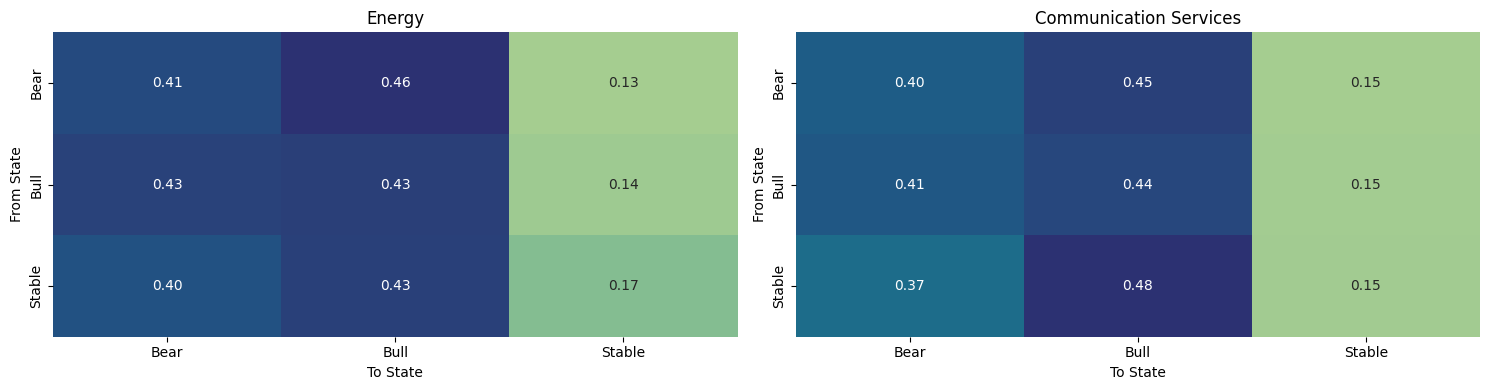

In [24]:
sectors_per_plot = 3

for i in range(0,len(sectors),sectors_per_plot):
    selected = sectors[i:i+sectors_per_plot]

    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))

    for ax, sector in zip(axes, selected):
        matrix = sector_transitions[sector]
        sns.heatmap(matrix, annot=True, cmap='crest', cbar=False, fmt='.2f', ax=ax,
                    xticklabels=['Bear','Bull','Stable'], yticklabels=['Bear','Bull','Stable'])
        ax.set_title(sector)
        ax.set_xlabel('To State')
        ax.set_ylabel('From State')

plt.tight_layout()
plt.show()

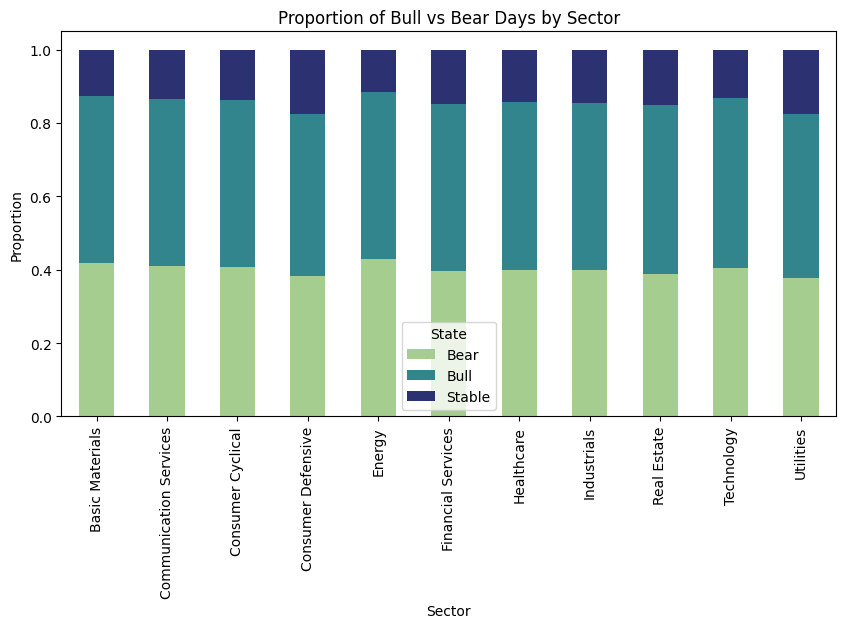

In [25]:
state_counts = (
    sp_sector.groupby(['Sector', 'State'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
)

state_counts.plot(kind='bar', stacked=True, figsize=(10,5), colormap='crest')
plt.title('Proportion of Bull vs Bear Days by Sector')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.show()

Interpretation

Analysis of sector-level matrices shows that most sectors display a similar trend to individual stocks. A near-even split between Bull and Bear days, with Stable days accounting for roughly 10-20%. Certain sectors, such as Utilities and Consumer Defensive, show slightly higher proportions of Stable days. Overall, the sector-level analysis aligns with the trends observed at the individual stock level.

# Simulation and Validation

Using the test dataset (2020–2024), we simulate sector-level state sequences based on the last observed state in the training set. The simulated transition matrices are then compared to the actual transition matrices for the same period.

In [26]:
#Splitting the dataa into test and train sets
test  = sp_stocks[sp_stocks['Date'] >= '2020-01-01']

test = test.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [27]:
train = sp_sector
train.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
1170097,2019-12-31,XYL,74.241714,78.790001,79.120003,78.239998,78.870003,492000.0,0.000635,Stable,Industrials,28458575872,0.000512
1170098,2019-12-31,YUM,91.778305,100.730003,101.169998,100.230003,100.669998,1271000.0,0.000894,Stable,Consumer Cyclical,36937969664,0.000665
1170099,2019-12-31,ZBH,140.075439,145.320389,145.349518,143.970871,143.970871,630772.0,0.006252,Bull,Healthcare,21324808192,0.000384
1170100,2019-12-31,ZBRA,255.440002,255.440002,256.470001,253.899994,253.899994,363500.0,0.005234,Bull,Technology,20273004544,0.000365
1170101,2019-12-31,ZTS,127.484680,132.350006,132.580002,131.449997,132.009995,1128600.0,0.001059,Stable,Healthcare,74370031616,0.001338


In [28]:
test.tail()


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
620452,2024-12-20,XYL,117.139999,117.139999,118.120003,115.900002,116.070000,2799600.0,0.006098,Bull,Industrials,28458575872,0.000512
620453,2024-12-20,YUM,132.360001,132.360001,133.380005,130.139999,130.250000,3212900.0,0.015342,Bull,Consumer Cyclical,36937969664,0.000665
620454,2024-12-20,ZBH,107.120003,107.120003,107.779999,105.339996,105.339996,3969100.0,0.012381,Bull,Healthcare,21324808192,0.000384
620455,2024-12-20,ZBRA,393.040009,393.040009,395.029999,382.850006,383.350006,826400.0,0.019903,Bull,Technology,20273004544,0.000365
620456,2024-12-20,ZTS,164.839996,164.839996,166.389999,163.529999,163.759995,6220100.0,0.008072,Bull,Healthcare,74370031616,0.001338


Simulation Phase

We take the last state from 2019 for each sector,then we simulate forward day-by-day from 2020–2024 using the training transition matrix. Each day’s next state is randomly chosen based on those pre-2020 probabilities.Finally, we compare these proportions to the real observed states.

In [29]:
def simulate_sector(start_state, transition_matrix, days):
    states = ['Bear','Bull','Stable']
    sequence = [start_state]
    for _ in range(days-1):
        probs = transition_matrix.loc[sequence[-1]].values
        next_state = random.choices(states, weights=probs, k=1)[0]
        sequence.append(next_state)
    return sequence

# Dictionary to store simulated sector states
simulated_sector_states = {}

for sector in sectors:
    # Starting state: last state from training data
    last_state = train[train['Sector']==sector].sort_values('Date')['State'].iloc[-1]
    
    # Number of days to simulate: unique dates in test for this sector
    days = test[test['Sector']==sector]['Date'].nunique()
    
    # Simulate sequence
    simulated_sector_states[sector] = simulate_sector(last_state, sector_transitions[sector], days)

# Create actual_states from the test dataset
actual_states = test[['Sector', 'State', 'Date']].copy()

# Compare simulated vs actual
for sector in sectors:
    sim_counts = pd.Series(simulated_sector_states[sector]).value_counts(normalize=True)
    actual_counts = actual_states[actual_states['Sector']==sector]['State'].value_counts(normalize=True)
    
    print(f"\nSector: {sector}")
    print("Simulated:", sim_counts.to_dict())
    print("Actual   :", actual_counts.to_dict())


Sector: Healthcare
Simulated: {'Bull': 0.4544728434504792, 'Bear': 0.3793929712460064, 'Stable': 0.16613418530351437}
Actual   : {'Bull': 0.45330431341511673, 'Bear': 0.43110407597942224, 'Stable': 0.11559161060546103}

Sector: Technology
Simulated: {'Bull': 0.46884984025559107, 'Bear': 0.41214057507987223, 'Stable': 0.11900958466453675}
Actual   : {'Bull': 0.4750329348621615, 'Bear': 0.42772383508172723, 'Stable': 0.09724323005611124}

Sector: Financial Services
Simulated: {'Bull': 0.4584664536741214, 'Bear': 0.40814696485623003, 'Stable': 0.13338658146964857}
Actual   : {'Bull': 0.469231319441133, 'Bear': 0.4195198130751991, 'Stable': 0.11124886748366793}

Sector: Consumer Defensive
Simulated: {'Bull': 0.4273162939297125, 'Bear': 0.3738019169329074, 'Stable': 0.1988817891373802}
Actual   : {'Bull': 0.4476177912626696, 'Bear': 0.4103950926719873, 'Stable': 0.1419871160653431}

Sector: Utilities
Simulated: {'Bull': 0.4145367412140575, 'Bear': 0.37859424920127793, 'Stable': 0.206869009

Interpretation

The results show that the simulation is able to capture the trend of the actual proportions with slight differences, maintaining the roughly equal split between Bull and Bear days, with Stable days taking 10–20%. Stable days are slightly overestimated in the simulation.

# Converting States to Price Movements

We convert the States to Price movement, by assigning percentage increase or decrease to each state.

Starting from the last training state, we simulate multiple price paths and compute the mean predicted price along with a 95% confidence interval.

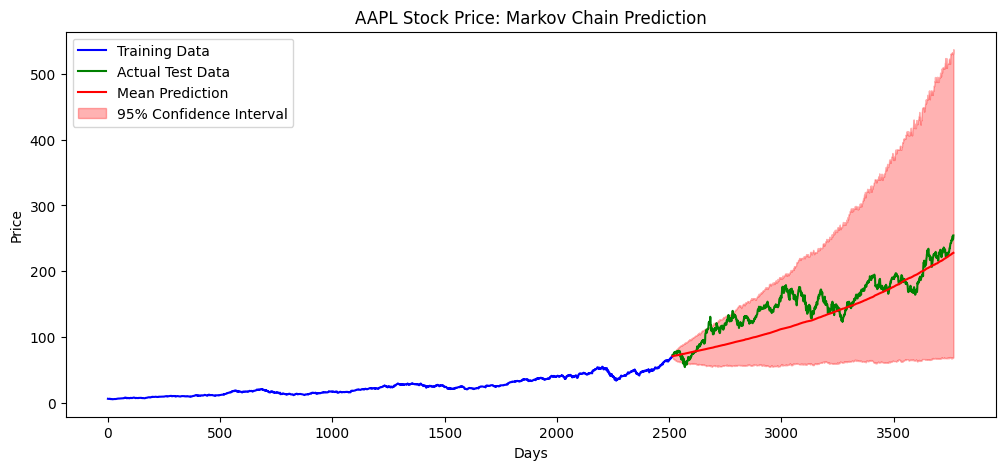

In [30]:
# Example for a single stock/sector
states = ['Bear', 'Bull', 'Stable']
state_to_return = {'Bear': -0.015, 'Stable': 0, 'Bull': 0.015}  # example daily return

# Get the last state from training as starting point
last_state = train[train['Symbol']=='AAPL'].iloc[-1]['State']
transition_matrix = transition_matrices['AAPL']  # or sector_transitions['Financial Services']

n_days = len(test[test['Symbol']=='AAPL'])
simulations = 1000  # number of simulations for CI
simulated_prices = np.zeros((simulations, n_days))

initial_price = train[train['Symbol']=='AAPL'].iloc[-1]['Adj Close']

for i in range(simulations):
    price = initial_price
    state = last_state
    for day in range(n_days):
        # Choose next state based on transition probabilities
        probs = transition_matrix.loc[state].values
        state = np.random.choice(states, p=probs)
        # Convert state to price change
        price *= 1 + state_to_return[state]
        simulated_prices[i, day] = price

# Compute mean and 95% CI
mean_pred = simulated_prices.mean(axis=0)
lower = np.percentile(simulated_prices, 2.5, axis=0)
upper = np.percentile(simulated_prices, 97.5, axis=0)

# Actual test prices
actual_prices = test[test['Symbol']=='AAPL']['Adj Close'].values
train_prices = train[train['Symbol']=='AAPL']['Adj Close'].values

# Plot
plt.figure(figsize=(12,5))
plt.plot(range(len(train_prices)), train_prices, color='blue', label='Training Data')
plt.plot(range(len(train_prices), len(train_prices)+len(actual_prices)), actual_prices, color='green', label='Actual Test Data')
plt.plot(range(len(train_prices), len(train_prices)+len(actual_prices)), mean_pred, color='red', label='Mean Prediction')
plt.fill_between(range(len(train_prices), len(train_prices)+len(actual_prices)), lower, upper, color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('AAPL Stock Price: Markov Chain Prediction')
plt.legend()
plt.show()

Interpretation

Comparing the simulated prices to actual prices shows that the mean prediction generally follows the real trend. Stocks with a clear underlying trend, like Apple, are captured more accurately, while volatile stocks are harder to predict. This limitation arises because the model only considers previous-day movements and does not account for longer-term seasonality or other external factors, especially random noise within the market.

# 4. Model Bootstrapping and Evaluation

In [32]:
df_companies = pd.read_csv('data/sp500_companies.csv')
df_index = pd.read_csv('data/sp500_index.csv')
df_index['Date'] = pd.to_datetime(df_index['Date'])
df_stocks = pd.read_csv('data/sp500_stocks.csv')

In [33]:
# Bootstrapping
n_boot = 2000
rmse_boot = np.zeros(n_boot)
mae_boot = np.zeros(n_boot)
n = len(y)
rng = np.random.default_rng(2)
for i in tqdm(range(n_boot)):
    sample = df_index.sample(n=n, replace=True, random_state=None)
    y_boot = sample['S&P500'].values
    x_boot = sample.index.values
    model_b = KernelReg([y_boot], [x_boot], var_type='c', reg_type='lc', bw=[20])
    yb_pred = model_b.fit(x)[0]
    rmse_boot[i] = np.sqrt(np.mean((y - yb_pred) ** 2))
    mae_boot[i] = np.mean(np.abs(y - yb_pred))

NameError: name 'tqdm' is not defined

/var/folders/4t/5hj7kljd5g51dtz6_yd5cv240000gn/T/ipykernel_2273/3687859544.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(rmse_boot, label='RMSE', fill=True, color='tab:blue')
/var/folders/4t/5hj7kljd5g51dtz6_yd5cv240000gn/T/ipykernel_2273/3687859544.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


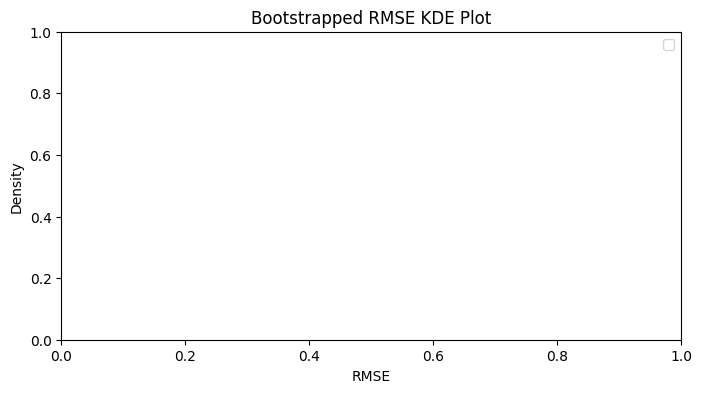

/var/folders/4t/5hj7kljd5g51dtz6_yd5cv240000gn/T/ipykernel_2273/3687859544.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(mae_boot, label='MAE', fill=True, color='tab:orange')
/var/folders/4t/5hj7kljd5g51dtz6_yd5cv240000gn/T/ipykernel_2273/3687859544.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


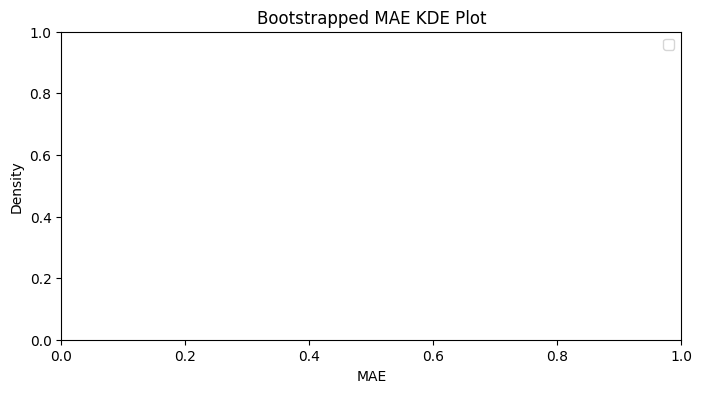

In [34]:
# KDE plot for RMSE
plt.figure(figsize=(8, 4))
sns.kdeplot(rmse_boot, label='RMSE', fill=True, color='tab:blue')
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.title('Bootstrapped RMSE KDE Plot')
plt.legend()
plt.show()

# KDE plot for MAE
plt.figure(figsize=(8, 4))
sns.kdeplot(mae_boot, label='MAE', fill=True, color='tab:orange')
plt.xlabel('MAE')
plt.ylabel('Density')
plt.title('Bootstrapped MAE KDE Plot')
plt.legend()
plt.show()

In [36]:
import plotly.figure_factory as ff


ModuleNotFoundError: No module named 'plotly'

In [ ]:
rmse_kde = ff.create_distplot(hist_data=[rmse_boot], group_labels=["RMSE"], bin_size=0.1)
rmse_kde.show()

In [ ]:
mse_kde = ff.create_distplot(hist_data=[mae_boot], group_labels=["MAE"], bin_size=0.1)
mse_kde.show()

# 6. Conclusion